In [19]:
from bot import get_historical_data
import pandas as pd
from binance.client import Client
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from itertools import combinations

In [2]:
transaction_costs = 0.0005

# Start investment is EURO!

In [55]:
# Fetch Bitcoin prices at 5-minute intervals for the last 40 days
symbol = 'BTCEUR'
days = 10000

bitcoin_data_hour = get_historical_data(symbol, Client.KLINE_INTERVAL_1HOUR, days)
bitcoin_data_5minute = get_historical_data(symbol, Client.KLINE_INTERVAL_5MINUTE, days)

In [56]:
bitcoin_data_hour["pct"] = bitcoin_data_hour["Close"].pct_change().shift(-1)    #time shift ist WICHTIG! einer der häufigsten Fehler, wenn er vergessen wird
bitcoin_data_5minute["pct"] = bitcoin_data_5minute["Close"].pct_change().shift(-1)

In [57]:
bitcoin_data_hour.dropna(inplace=True)
bitcoin_data_5minute.dropna(inplace=True)

df_hour = bitcoin_data_hour
df_5minute = bitcoin_data_5minute

In [58]:
def sharpe_ratio(s: pd.Series):
    sharpe = s.mean() / s.std()
    return sharpe

In [ ]:
#Funktion um zu zählen wie häufig ein buy Signal hinter einander auftritt
def count_consecutive_ones(data: pd.DataFrame, signal_col: str):
    new_column_name = signal_col + "_count"
    
    count = 0
    counts = []
    
    for value in data[signal_col]:
        if value == 1:
            count += 1
        else:
            count = 0
        counts.append(count)
    
    data[new_column_name] = counts

### Indikatoren und Indexe berechnen

In [82]:
def OBV_berechnen(data:pd.DataFrame):
    #benötigt ein DataFrame mit den Spalten "4a. close (EUR)" und "5. volume"
    data["OBV"] = (np.sign(data["Close"].pct_change()) * data["Volume"]).cumsum()
    
def SMA_berechnen(data:pd.DataFrame, intervall:int):
    spalten_name = "SMA_"+str(intervall)
    daten[spalten_name] = daten["Close"].rolling(intervall).mean()
    spalten_name_sig = "SMA_"+str(intervall)+"_Sig"
    daten[spalten_name_sig] = daten["Close"]>daten[spalten_name]
    count_consecutive_ones(data, spalten_name_sig)
    
def RSI_berechnen(data:pd.DataFrame, intervall:int):

    spalten_name = "RSI_"+str(intervall)

    # Bestimme die Preisänderung zum jeweiligen Zeitpunkt t-1
    delta = data["Close"].diff()

    # Get rid of the first row, which has NaN values
    delta = delta[1:]

    # Calculate the gains and losses
    up = delta.where(delta > 0, 0)
    down = -delta.where(delta < 0, 0)

    # Calculate the rolling average of the gains and losses
    #window_size = 14 #als default
    avg_gain = up.rolling(intervall).mean()
    avg_loss = down.rolling(intervall).mean()

    # Calculate the relative strength
    rs = avg_gain / avg_loss

    # Calculate the RSI
    data[spalten_name] = 100 - (100 / (1 + rs))
    
def EMA_berechnen(data: pd.DataFrame, intervall: int):
    spalten_name = "EMA_" + str(intervall)
    data[spalten_name] = data["Close"].ewm(span=intervall, adjust=False).mean()
    spalten_name_sig = "EMA_"+str(intervall)+"_Sig"
    daten[spalten_name_sig] = daten["Close"]>daten[spalten_name]
    count_consecutive_ones(data, spalten_name_sig)

def HMA_berechnen(data: pd.DataFrame, intervall: int):
    spalten_name = "HMA_" + str(intervall)
    half_length = int(intervall / 2)
    sqrt_length = int(np.sqrt(intervall))

    wma_half = data["Close"].rolling(window=half_length).mean()
    wma_full = data["Close"].rolling(window=intervall).mean()

    raw_hma = 2 * wma_half - wma_full
    data[spalten_name] = raw_hma.rolling(window=sqrt_length).mean()
    
    spalten_name_sig = "HMA_"+str(intervall)+"_Sig"
    daten[spalten_name_sg] = daten["Close"]>daten[spalten_name]
    count_consecutive_ones(data, spalten_name_sig)

def MACD_berechnen(data: pd.DataFrame, fast_period: int = 12, slow_period: int = 26, signal_period: int = 9):
    data["MACD"] = data["Close"].ewm(span=fast_period, adjust=False).mean() - data["Close"].ewm(span=slow_period, adjust=False).mean()
    data["MACD_Signal"] = data["MACD"].ewm(span=signal_period, adjust=False).mean()

def Momentum_berechnen(data: pd.DataFrame, intervall: int):
    spalten_name = "Momentum_" + str(intervall)
    data[spalten_name] = data["Close"].diff(intervall)

def Stochastic_RSI_berechnen(data: pd.DataFrame, intervall: int):
    spalten_name = "StochRSI_" + str(intervall)

    delta = data["Close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=intervall).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=intervall).mean()

    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))

    min_RSI = RSI.rolling(window=intervall).min()
    max_RSI = RSI.rolling(window=intervall).max()

    data[spalten_name] = (RSI - min_RSI) / (max_RSI - min_RSI)

In [80]:
indicators = []

OBV_berechnen(df_hour)
MACD_berechnen(df_hour)
for i in [5, 10, 20, 50, 100, 500, 1000]:
    RSI_berechnen(df_hour, i)
    EMA_berechnen(df_hour, i)
    HMA_berechnen(df_hour, i)
    Momentum_berechnen(df_hour, i)
    Stochastic_RSI_berechnen(df_hour, i)
    indicators.extend([f"RSI_{i}", f"EMA_{i}", f"HMA_{i}", f"Momentum_{i}", f"StochRSI_{i}"])

In [74]:
#berechnet performance für das gewollte Zeitfenster
def create_labels(data: pd.DataFrame, window: int):
    data["future_return"] = data["Close"].shift(-window) / data["Close"] - 1
    data["label"] = (data["future_return"] > 0.0).astype(int)
    data.dropna(inplace=True)

In [ ]:
def train_decision_tree(data: pd.DataFrame, features: list, target: str):
    # Indizes zurücksetzen, um Probleme mit der Indizierung zu vermeiden
    data = data.reset_index(drop=True)
    
    # Aufteilen der Daten in Trainings- und Testdaten
    train_size = int(len(data) * 0.8)
    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size:]
    X_train = train_data[features]
    X_test = test_data[features]
    y_train = train_data[target]
    y_test = test_data[target]

    # Definiere den Parameterbereich für GridSearch
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4, 10, 20, 30],
        'max_features': [None, 'sqrt', 'log2']
    }
    
    # Definiere den Precision-Scorer
    precision_scorer = make_scorer(precision_score, pos_label=1)
    
    # Initialisiere den GridSearchCV
    grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                               param_grid=param_grid,
                               cv=5,  # Anzahl der Cross-Validation-Folds
                               scoring=precision_scorer,  # Bewertungskriterium
                               n_jobs=-1,  # Nutze alle verfügbaren CPU-Kerne
                               verbose=2)  # Ausgabe von Fortschrittsinformationen

    # Führe GridSearch aus
    grid_search.fit(X_train, y_train)
    
    # Ausgabe der besten Parameter
    print("Beste Parameter:", grid_search.best_params_)
    
    # Modell mit den besten Parametern
    best_clf = grid_search.best_estimator_
    
    # Vorhersagen auf Testdaten
    y_pred = best_clf.predict(X_test)
    
    #y_pred = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
    #print(y_pred)
    print(classification_report(y_test, y_pred))

    # Berechne die Sharpe Ratio
    test_returns = data.loc[X_test.index, "future_return"]
    strat_returns = test_returns[y_pred == 1]  # Returns when model predicts 1

    sharpe = sharpe_ratio(strat_returns)
    print(f"Sharpe Ratio: {sharpe}")
    
    # Performance DataFrame erstellen
    PF = pd.DataFrame(data["pct"].iloc[X_test.index])
    PF["pred"] = y_pred
    PF["strategy_returns"] = PF["pred"] * PF["pct"]
    PF["cumulative_strategy_returns"] = (PF["strategy_returns"] + 1).cumprod()

    PF["benchmark_returns"] = PF["pct"]
    PF["cumulative_benchmark_returns"] = (PF["benchmark_returns"] + 1).cumprod()
    
    # Plotten der Ergebnisse
    plt.figure(figsize=(14, 7))
    plt.plot(PF["cumulative_strategy_returns"], label="Strategy Returns")
    plt.plot(PF["cumulative_benchmark_returns"], label="Benchmark Returns")
    plt.title("Cumulative Returns")
    plt.xlabel("Time")
    plt.ylabel("Cumulative Returns")
    plt.legend()
    plt.show()
    
    return clf, sharpe

In [76]:
def find_best_indicators(data: pd.DataFrame, indicators: list, target: str):
    best_sharpe = -np.inf
    best_combination = None
    best_model = None

    for r in range(1, len(indicators) + 1):
        for combo in combinations(indicators, r):
            print(combo)
            features = list(combo)
            clf, sharpe = train_decision_tree(data, features, target)
            if sharpe > best_sharpe:
                best_sharpe = sharpe
                best_combination = combo
                best_model = clf

    print(f"Best Sharpe Ratio: {best_sharpe}")
    print(f"Best Indicator Combination: {best_combination}")

    return best_model, best_combination, best_sharpe

('OBV',)
              precision    recall  f1-score   support

           0       0.49      0.51      0.50      3167
           1       0.52      0.51      0.51      3332

    accuracy                           0.51      6499
   macro avg       0.51      0.51      0.51      6499
weighted avg       0.51      0.51      0.51      6499

Sharpe Ratio: 0.014970359266591843


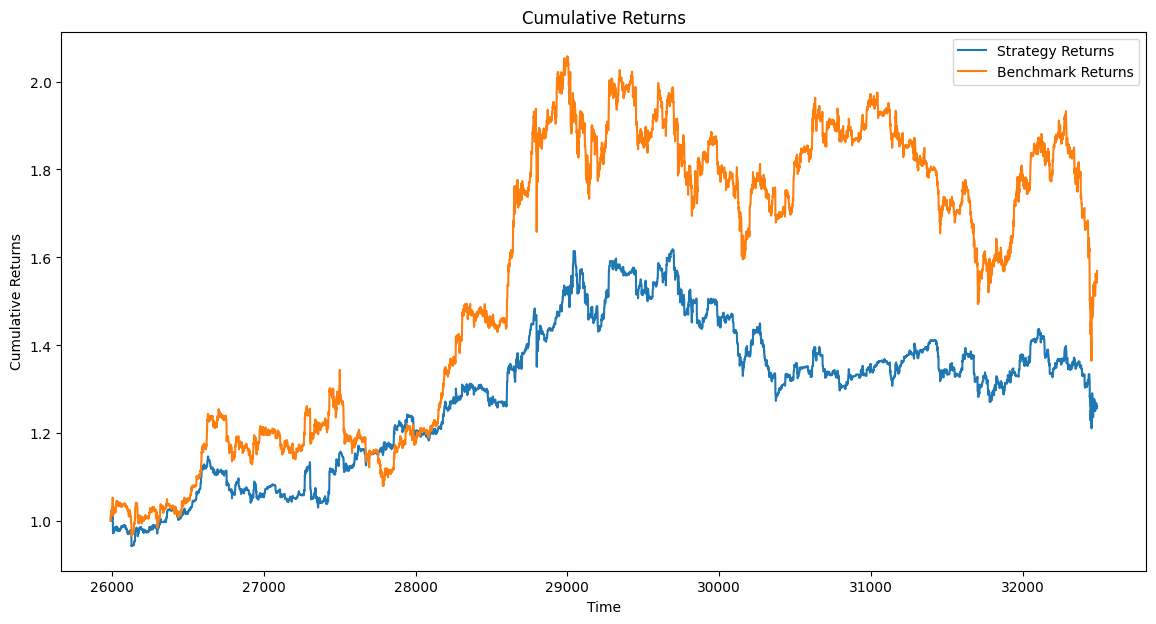

('RSI_5',)
              precision    recall  f1-score   support

           0       0.48      0.49      0.49      3167
           1       0.51      0.50      0.50      3332

    accuracy                           0.50      6499
   macro avg       0.50      0.50      0.50      6499
weighted avg       0.50      0.50      0.50      6499

Sharpe Ratio: 0.012603441505386764


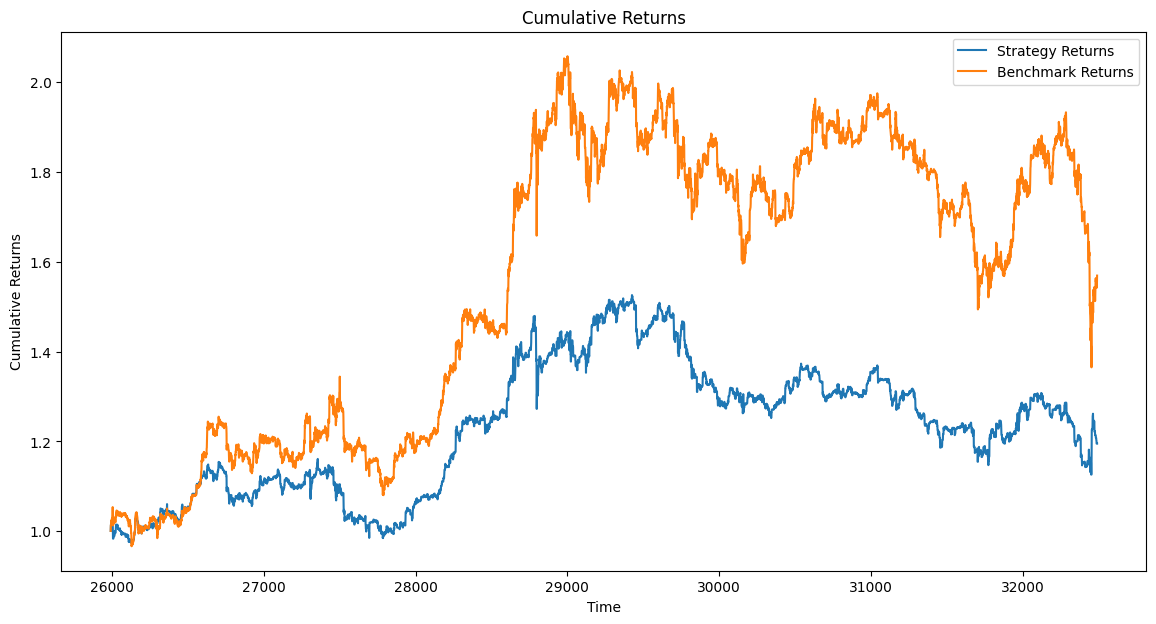

('RSI_10',)
              precision    recall  f1-score   support

           0       0.48      0.50      0.49      3167
           1       0.51      0.49      0.50      3332

    accuracy                           0.50      6499
   macro avg       0.50      0.50      0.50      6499
weighted avg       0.50      0.50      0.50      6499

Sharpe Ratio: 0.004793990017466034


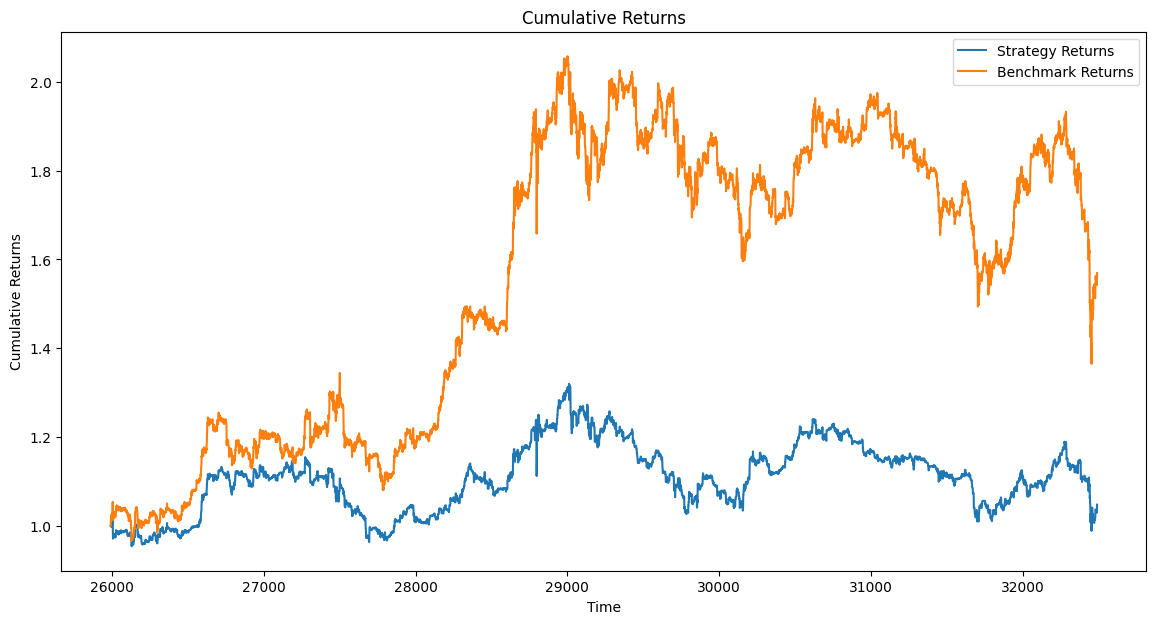

('OBV', 'RSI_5')
              precision    recall  f1-score   support

           0       0.49      0.51      0.50      3167
           1       0.52      0.51      0.51      3332

    accuracy                           0.51      6499
   macro avg       0.51      0.51      0.51      6499
weighted avg       0.51      0.51      0.51      6499

Sharpe Ratio: 0.032731064146095466


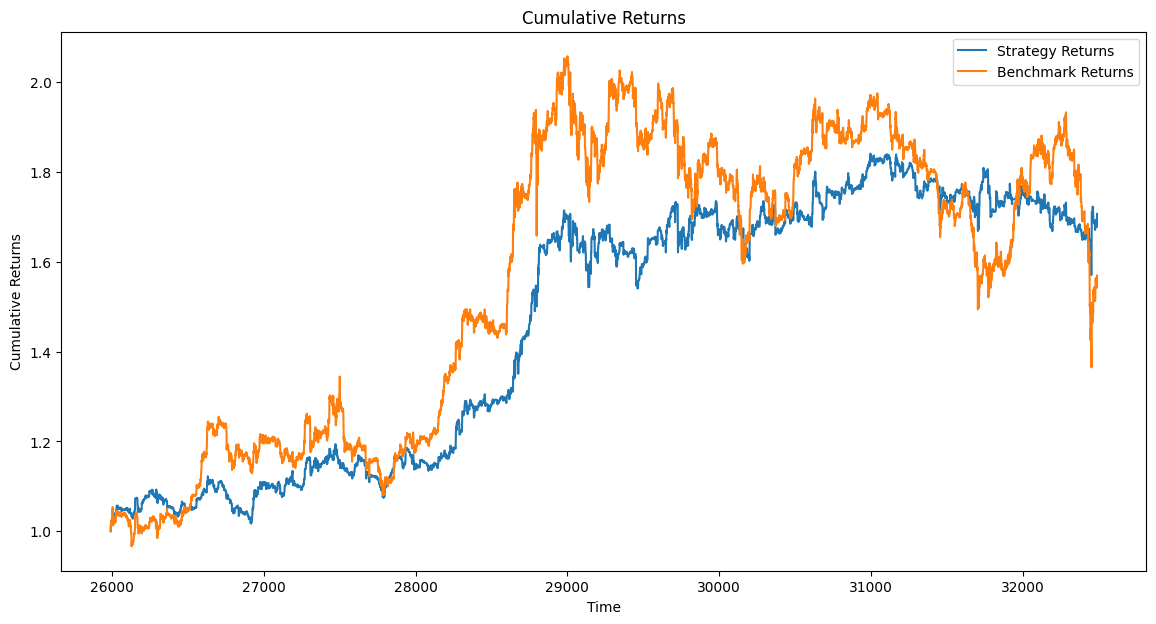

('OBV', 'RSI_10')
              precision    recall  f1-score   support

           0       0.48      0.50      0.49      3167
           1       0.51      0.49      0.50      3332

    accuracy                           0.50      6499
   macro avg       0.50      0.50      0.50      6499
weighted avg       0.50      0.50      0.50      6499

Sharpe Ratio: 0.01779708323799592


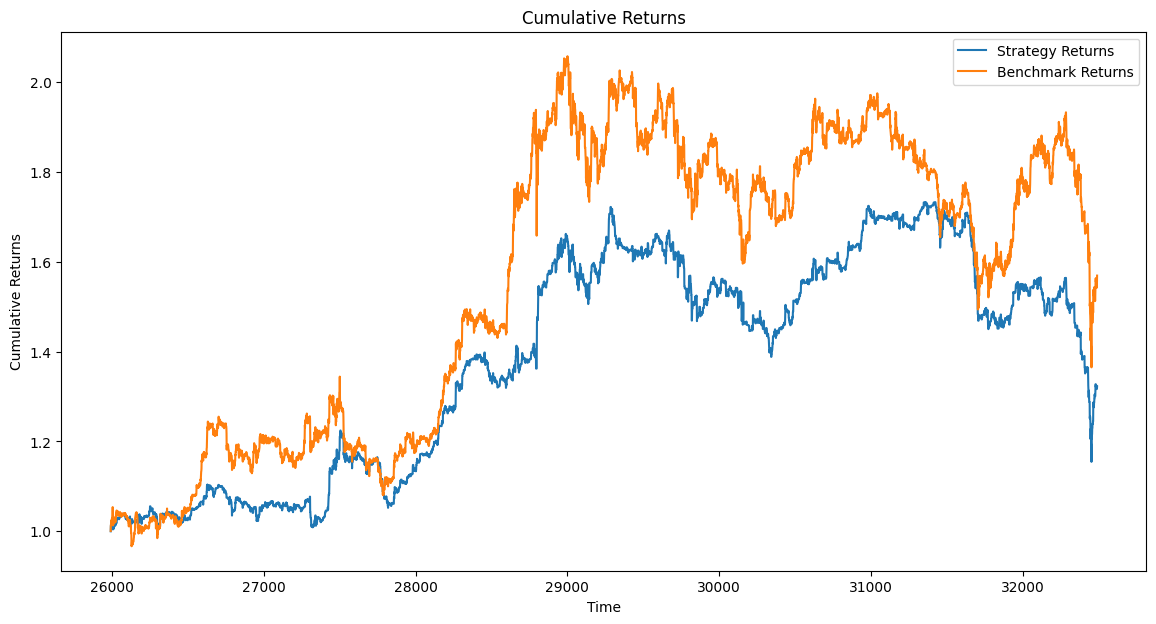

('RSI_5', 'RSI_10')
              precision    recall  f1-score   support

           0       0.49      0.48      0.48      3167
           1       0.51      0.52      0.52      3332

    accuracy                           0.50      6499
   macro avg       0.50      0.50      0.50      6499
weighted avg       0.50      0.50      0.50      6499

Sharpe Ratio: 0.008304363393748756


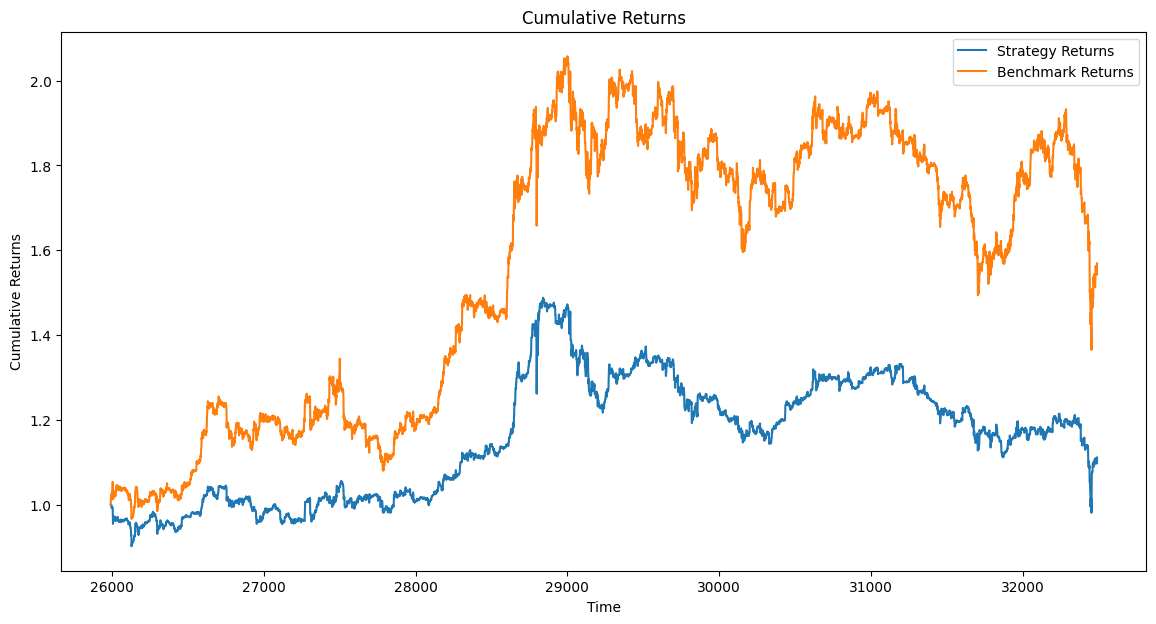

('OBV', 'RSI_5', 'RSI_10')
              precision    recall  f1-score   support

           0       0.48      0.51      0.50      3167
           1       0.51      0.48      0.49      3332

    accuracy                           0.50      6499
   macro avg       0.50      0.50      0.50      6499
weighted avg       0.50      0.50      0.50      6499

Sharpe Ratio: 0.007616614079326453


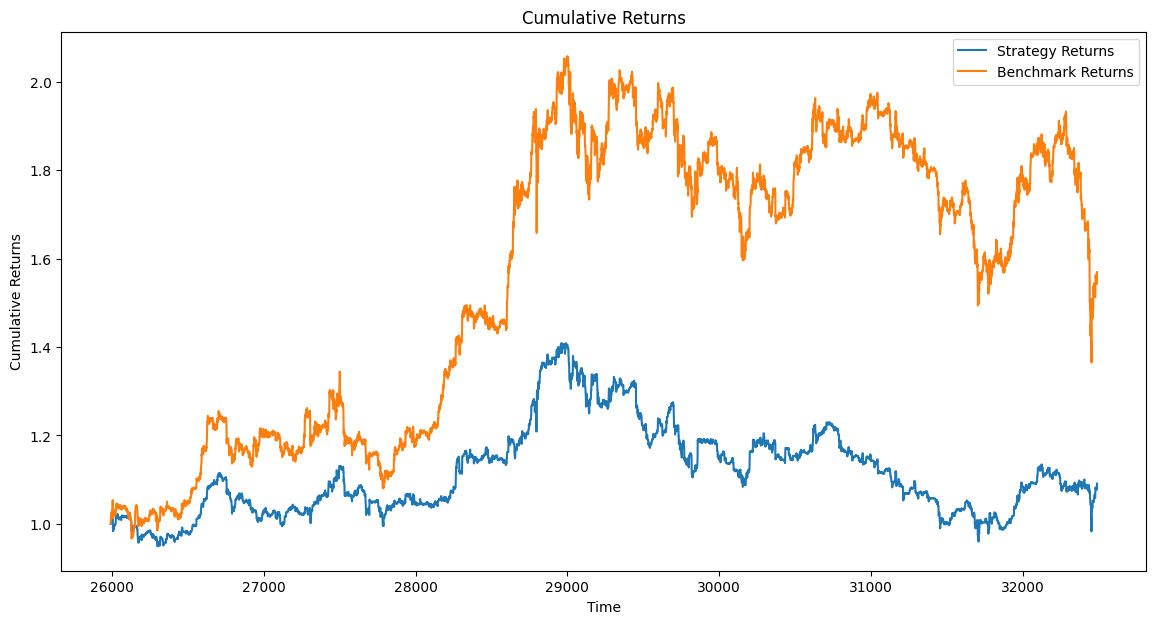

Best Sharpe Ratio: 0.032731064146095466
Best Indicator Combination: ('OBV', 'RSI_5')


In [84]:
# Labels erstellen
create_labels(df_hour, window=1)

# Liste der Indikatoren
features = ["OBV", "RSI_5", "RSI_10"]#, "RSI_50", "RSI_50", "MACD", "MACD_Signal", "Momentum_10", "StochRSI_10", "StochRSI_20", "StochRSI_50"]

# Beste Indikatoren finden
best_model, best_combination, best_sharpe = find_best_indicators(df_hour, features, "label")

man könnte probieren, zu zählen wie häufig die Buy-Signale bei den Averages hintereinander aufkommen und das dann in den DT übergeben. 